# Explicando ANN (Clasificación) para identificar depresión

## Preparación de los datos

Lectura de los datos de acuerdo a sus datasets

In [121]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("Dataset_MO_ENG.csv")
dm = pd.read_csv("Dataset_QS_METRICS.csv")

Determinación de las preguntas con mayor metrica especifica obtenidas por fuerza bruta

In [122]:
dm = dm.sort_values(by = "Recall_2", ascending = False)

Ordenación de los datos de acuerdo a la metrica de importancia

In [123]:
question = dm.iloc[:, 0].to_numpy().tolist()
accurracy = dm.iloc[:, 1].to_numpy().tolist()

presicion_0 = dm.iloc[:, 2].to_numpy().tolist()
recall_0 = dm.iloc[:, 3].to_numpy().tolist()
f1_score_0 = dm.iloc[:, 4].to_numpy().tolist()

presicion_1 = dm.iloc[:, 6].to_numpy().tolist()
recall_1 = dm.iloc[:, 7].to_numpy().tolist()
f1_score_1 = dm.iloc[:, 8].to_numpy().tolist()

presicion_2 = dm.iloc[:, 10].to_numpy().tolist()
recall_2 = dm.iloc[:, 11].to_numpy().tolist()
f1_score_2 = dm.iloc[:, 12].to_numpy().tolist()

Determinación de las preguntas con mayor metrica

In [124]:
#questionSelect = []
#
#umbral = 60
#
#index = -1
#for metric in accurracy:
#    index += 1
#    if metric >= umbral:
#        questionSelect.append(question[index])
#        # if len(questionSelect) == 20:
#        #    break
#    
#questionSelect.sort()
#    
#print("Preguntas con mayor recall: " + str(questionSelect))
#print("Total de preguntas:" + str(len(questionSelect)))

Eliminación de las preguntas fisicas - relativas

In [125]:
df = df.drop(df.columns[102:-1], axis=1)

Eliminación de las preguntas con mayor metrica

In [126]:
## list of contradictory questions
#l_contr = [3,4,5,14,21,24,25,26,27,29,30,32,48,49,51,54,55,58,59,60,62,63,66,68,
#    70,75,78,83,85,86,87,89,90,91,94,95,96,98,100,101]

## list of contradictory questions
l_contr = [4, 6, 13, 14, 25, 26, 27, 28, 31, 33, 34, 36, 38, 39, 41, 42, 45, 46, 49, 50, 51, 52, 54, 55,
          58, 60, 61, 64, 65, 66, 68, 69, 72, 73, 78, 84, 91, 92, 94, 96, 97, 101]
l_contr.sort()

i=0
for x in l_contr:
    df.drop(df.columns[x-(i+1)],axis=1, inplace=True)
    i = i+1
    
questionSelect = l_contr

#i = 0
#for x in questionSelect:
#    df.drop(df.columns[x-(i+1)],axis=1, inplace=True)
#    i = i+1

Agrupación de los targets en las nuevas clases Low, Medium y High

In [127]:
dic = { 1: 0 , 2: 0, 3:1, 4:2, 5:2} 
df['Target'] = df['Target'].map(dic)
    
train_cols = df.columns[0:-1]
label = df.columns[-1]
X = df[train_cols]
y = df[label]
target_names=["Low","Medium","High"]

## Equilibración de los datos

Uso del oversampling con SMOTE

In [128]:
from imblearn.over_sampling import SMOTE
random_state = 13
oversample = SMOTE(random_state=random_state)
X, y = oversample.fit_resample(X, y)

## Preparación del entrenamiento de la red neuronal

Asignación de los datos de entrenamiento

In [129]:
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

## Entrenamiento de la red neuronal

Entrenamiento por medio de diferentes conbinaciones por medio de la validación cruzada con alpha regular

In [130]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

cv_scores_mean=[]
cv_scores_std=[]

regul_param_range = 10.0 ** -np.arange(-2, 7)
for regul_param in regul_param_range:
    mlp=MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', solver='adam', alpha=regul_param, 
             learning_rate='constant', learning_rate_init=0.0001, max_iter=100000, random_state=seed)
    
    scores = cross_val_score(mlp, X, y, cv=5, scoring='f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())

cv_scores_mean, cv_scores_std

([0.1632974910394265,
  0.22120229706436603,
  0.28310914575620455,
  0.28310914575620455,
  0.27632916103504335,
  0.27632916103504335,
  0.27632916103504335,
  0.27632916103504335,
  0.27632916103504335],
 [0.006619092595549127,
  0.052655265251461345,
  0.08461885410568176,
  0.08461885410568176,
  0.07403933966805967,
  0.07403933966805967,
  0.07403933966805967,
  0.07403933966805967,
  0.07403933966805967])

Generación de la grafica de curva de aprendizaje con alpha regular

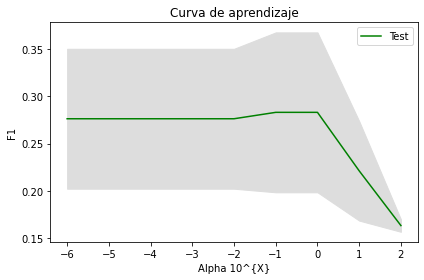

In [131]:
import matplotlib.pyplot as plt

plt.plot(np.log10(regul_param_range), cv_scores_mean, color="g", label="Test")

lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color="#DDDDDD")

plt.title("Curva de aprendizaje")
plt.xlabel("Alpha 10^{X}"), plt.ylabel("F1"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Entrenamiento por medio de diferentes conbinaciones por medio de la validación cruzada con alpha en 1

In [132]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

cv_scores_mean=[]
cv_scores_std=[]

regul_param_range = 10.0 ** -np.arange(0, 7)
for regul_param in regul_param_range:
    mlp=MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', solver='adam', alpha=1, 
             learning_rate='constant', learning_rate_init=regul_param, max_iter=100000, random_state=seed)
    
    scores = cross_val_score(mlp, X, y, cv=5, scoring='f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())

cv_scores_mean, cv_scores_std

([0.16989247311827954,
  0.47336267963202944,
  0.44588438794321145,
  0.4400336373865786,
  0.28310914575620455,
  0.192151348013417,
  0.192151348013417],
 [0.002633859938476533,
  0.06350866559434944,
  0.062249623451764734,
  0.07170676112117981,
  0.08461885410568176,
  0.036543909929773126,
  0.036543909929773126])

Generación de la grafica de curva de aprendizaje con alpha 1

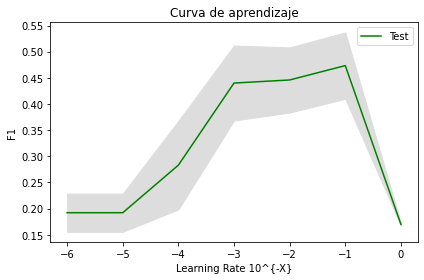

In [133]:
import matplotlib.pyplot as plt

plt.plot(np.log10(regul_param_range), cv_scores_mean, color="g", label="Test")

lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color="#DDDDDD")

plt.title("Curva de aprendizaje")
plt.xlabel("Learning Rate 10^{-X}"), plt.ylabel("F1"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Generación del modelo final de la red neuronal

Se genera el modelo final de la red neuronal a partir de los datos anteriormente entrenados

In [134]:
mlp=MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', solver='adam', alpha=0.001, 
             learning_rate='constant', learning_rate_init=0.1, max_iter=100000, random_state=42)

mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(10,),
              learning_rate_init=0.1, max_iter=100000, random_state=42)

Se guarda el modelo final de la red neuronal

In [135]:
import joblib

joblib.dump(mlp,"modelo_depresion.pkl")

['modelo_depresion.pkl']

## Preparación de la explicabilidad del red neuronal

Uso del counterfactuals para la explicabilidad

In [136]:
import dice_ml
d = dice_ml.Data(dataframe=df, continuous_features=[], outcome_name='Target')
m = dice_ml.Model(model=mlp, backend="sklearn")
exp = dice_ml.Dice(d, m, method="random")

e1 = exp.generate_counterfactuals(query_instances=X_test[0:2], total_CFs=2, desired_class=2)
e1.visualize_as_dataframe(show_only_changes=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.44it/s]

Query instance (original outcome : 1)


,1. Most of the time I have difficulty concentrating on simple tasks,2. I don't feel like doing my daily duties,3. My friends or family have told me that I look different,7. My hobbies are still important to me,8. I'm still as punctual as I have always been,"9. If I had the chance, I would spend all day in my bed",10. I have found that I can spend a lot of time scrolling the screen \nof my cell phone without searching or stopping at anything in particular,"11. When someone asks me something, I have noticed that I take longer than normal to\nrespond",12. I have noticed my body shaken without any cause,15. In recent months I usually reproach myself for things from the past,...,88,89. It makes me laugh when my superiors at school or at work demand something,90. Deceiving people is not wrong if it is to achieve something important,93. People steal because they have needs,95. Neighbors must put up with each other's noises without complaining,98. It is normal to change jobs several times a year,99. It is important to respect turns,100. I could pretend to be someone else to achieve what I want,"102. I have a hard time taking ""no"" for an answer",Target
0,1,0,1,1,0,0,0,0,0,0,...,0,0,1,0,1,1,0,1,1,1



Diverse Counterfactual set (new outcome: 2)


,1. Most of the time I have difficulty concentrating on simple tasks,2. I don't feel like doing my daily duties,3. My friends or family have told me that I look different,7. My hobbies are still important to me,8. I'm still as punctual as I have always been,"9. If I had the chance, I would spend all day in my bed",10. I have found that I can spend a lot of time scrolling the screen \nof my cell phone without searching or stopping at anything in particular,"11. When someone asks me something, I have noticed that I take longer than normal to\nrespond",12. I have noticed my body shaken without any cause,15. In recent months I usually reproach myself for things from the past,...,88,89. It makes me laugh when my superiors at school or at work demand something,90. Deceiving people is not wrong if it is to achieve something important,93. People steal because they have needs,95. Neighbors must put up with each other's noises without complaining,98. It is normal to change jobs several times a year,99. It is important to respect turns,100. I could pretend to be someone else to achieve what I want,"102. I have a hard time taking ""no"" for an answer",Target
0,-,-,-,-,-,-,1,-,-,-,...,-,1,-,-,-,-,-,-,-,2
1,-,-,-,-,-,-,-,-,-,-,...,-,-,1,-,0,-,-,-,-,2


Query instance (original outcome : 0)


,1. Most of the time I have difficulty concentrating on simple tasks,2. I don't feel like doing my daily duties,3. My friends or family have told me that I look different,7. My hobbies are still important to me,8. I'm still as punctual as I have always been,"9. If I had the chance, I would spend all day in my bed",10. I have found that I can spend a lot of time scrolling the screen \nof my cell phone without searching or stopping at anything in particular,"11. When someone asks me something, I have noticed that I take longer than normal to\nrespond",12. I have noticed my body shaken without any cause,15. In recent months I usually reproach myself for things from the past,...,88,89. It makes me laugh when my superiors at school or at work demand something,90. Deceiving people is not wrong if it is to achieve something important,93. People steal because they have needs,95. Neighbors must put up with each other's noises without complaining,98. It is normal to change jobs several times a year,99. It is important to respect turns,100. I could pretend to be someone else to achieve what I want,"102. I have a hard time taking ""no"" for an answer",Target
0,1,0,0,1,1,0,1,1,0,1,...,0,0,0,0,1,1,0,1,1,0



Diverse Counterfactual set (new outcome: 2)


,1. Most of the time I have difficulty concentrating on simple tasks,2. I don't feel like doing my daily duties,3. My friends or family have told me that I look different,7. My hobbies are still important to me,8. I'm still as punctual as I have always been,"9. If I had the chance, I would spend all day in my bed",10. I have found that I can spend a lot of time scrolling the screen \nof my cell phone without searching or stopping at anything in particular,"11. When someone asks me something, I have noticed that I take longer than normal to\nrespond",12. I have noticed my body shaken without any cause,15. In recent months I usually reproach myself for things from the past,...,88,89. It makes me laugh when my superiors at school or at work demand something,90. Deceiving people is not wrong if it is to achieve something important,93. People steal because they have needs,95. Neighbors must put up with each other's noises without complaining,98. It is normal to change jobs several times a year,99. It is important to respect turns,100. I could pretend to be someone else to achieve what I want,"102. I have a hard time taking ""no"" for an answer",Target
0,-,-,-,-,-,-,-,1,-,-,...,-,-,-,-,-,-,-,-,-,2
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,0,-,-,-,-,-,2


## Explicación de la red neuronal

Preparación de los datos para la explicación de la red neuronal

In [137]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

X_test.columns = X.columns.str.replace(r".", "")
explainer = ClassifierExplainer(mlp, X_test, y_test)
#ExplainerDashboard(explainer).run(port=8052)

Note: shap values for shap='kernel' normally get calculated against X_background, but paramater X_background=None, so setting X_background=shap.sample(X, 50)...
Generating self.shap_explainer = shap.KernelExplainer(model, X, link='identity')


The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 1 Most of the time I have difficulty concentrating on simple tasks
- 10 I have found that I can spend a lot of time scrolling the screen 
of my cell phone without searching or stopping at anything in particular
- 100 I could pretend to be someone else to achieve what I want
- 102 I have a hard time taking  "no" for an answer
- 11 When someone asks me something, I have noticed that I take longer than normal to
respond
- ...
Feature names seen at fit time, yet now missing:
- 1. Most of the time I have difficulty concentrating on simple tasks
- 10. I have found that I can spend a lot of time scrolling the screen 
of my cell phone without searching or stopping

Explicación del modelo por medio de la matrix de confusión

In [138]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = mlp.predict(X_test)

print('Matrix de confusión:')
print(confusion_matrix(y_test,y_pred))
print()
print('Classification accuracy =',accuracy_score(y_test,y_pred)*100,'%\n')
print(classification_report(y_test,y_pred))

Matrix de confusión:
[[4 3 4]
 [8 4 2]
 [5 2 7]]

Classification accuracy = 38.46153846153847 %

              precision    recall  f1-score   support

           0       0.24      0.36      0.29        11
           1       0.44      0.29      0.35        14
           2       0.54      0.50      0.52        14

    accuracy                           0.38        39
   macro avg       0.41      0.38      0.38        39
weighted avg       0.42      0.38      0.39        39



The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 1 Most of the time I have difficulty concentrating on simple tasks
- 10 I have found that I can spend a lot of time scrolling the screen 
of my cell phone without searching or stopping at anything in particular
- 100 I could pretend to be someone else to achieve what I want
- 102 I have a hard time taking  "no" for an answer
- 11 When someone asks me something, I have noticed that I take longer than normal to
respond
- ...
Feature names seen at fit time, yet now missing:
- 1. Most of the time I have difficulty concentrating on simple tasks
- 10. I have found that I can spend a lot of time scrolling the screen 
of my cell phone without searching or stopping at anything in particular
- 100. I could pretend to be someone else to achieve what I want
- 102. I have a hard time taking  "no" for an answer
- 11. When someone asks me something, I ha

# Almacenamiento de los datos

Se recuperan los valores de importancia y se almacenan para escritura

In [139]:
from sklearn import metrics
clf_rep = metrics.precision_recall_fscore_support(y_test,y_pred)

Se prepara los datos recuperados para su escritura

In [140]:
accuracy = accuracy_score(y_test,y_pred)*100
precision = [clf_rep[0][0], clf_rep[0][1], clf_rep[0][2]]
recall = [clf_rep[1][0], clf_rep[1][1], clf_rep[1][2]]
f1_score = [clf_rep[2][0], clf_rep[2][1], clf_rep[2][2]]
support = [clf_rep[3][0], clf_rep[3][1], clf_rep[3][2]]

metrics = pd.DataFrame([[questionSelect,accuracy,precision[0],recall[0],f1_score[0],support[0],
                                              precision[1],recall[1],f1_score[1],support[1],
                                              precision[2],recall[2],f1_score[2],support[2]]],
                        columns = ['Question','Acurracy global','Precision_0','Recall_0','F1_score_0', 'Support_0',
                                                                'Precision_1','Recall_1','F1_score_1', 'Support_1',
                                                                'Precision_2','Recall_2','F1_score_2', 'Support_2'])

metrics

,Question,Acurracy global,Precision_0,Recall_0,F1_score_0,Support_0,Precision_1,Recall_1,F1_score_1,Support_1,Precision_2,Recall_2,F1_score_2,Support_2
0,"[4, 5, 6, 13, 14, 25, 26, 27, 28, 31, 33, 34, ...",38.461538,0.235294,0.363636,0.285714,11,0.444444,0.285714,0.347826,14,0.538462,0.5,0.518519,14


Se escriben los datos preparados en el dataset correspondiente

In [141]:
metrics.to_csv(r"Dataset_QS_TEST.csv", mode = 'a', header = False, index = False)